In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split, TestData
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.eval_util.evaluation import evaluate_model
from gluonts.ev.metrics import MAE, MAPE

from mov_av import moving_average
from uni2ts.alex.common.benchmark_func import *

In [4]:
it_data_23_24 = pd.read_csv('data/it_load_data_23_24.csv', delimiter=',')
it_data_23_24['DateUTC'] = pd.to_datetime(it_data_23_24['DateUTC'])
it_data_23_24 = it_data_23_24.set_index('DateUTC')

In [5]:
def get_metrics_v2(model_folder: str, data: pd.DataFrame):
    metrics = {"mean": [], "median": [], "lower_0025": [], "upper_0975": []}
    for i in range(1, 52):
        try:
            model, test_data = get_model_data(
                                    model_folder=model_folder,
                                    prediction_lenght=168,
                                    num_of_weeks=i,
                                    data=data,
                                    patch_size="auto",
                                    num_samples=20,
                                )
            
            forecast_samples, target_values = get_eval_foreasts(model, test_data)
    
            # absolute error of the average forecast of each time step
            mean_error_ts = (np.mean(forecast_samples, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            mean_error_ts = np.abs(mean_error_ts)
    
            # absolute error of the median forecast of each time step
            median_error_ts = (np.quantile(forecast_samples, 0.5, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            median_error_ts = np.abs(median_error_ts)
    
            # absolute error of the 97.5th percentile forecast of each time step
            upper_error_ts = (np.quantile(forecast_samples, 0.975, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            upper_error_ts = np.abs(upper_error_ts)
    
            # absolute error of the 2.5th percentile forecast of each time step
            lower_error_ts = (np.quantile(forecast_samples, 0.025, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            lower_error_ts = np.abs(lower_error_ts)
    
            metrics['mean'].append(mean_error_ts)
            metrics['median'].append(median_error_ts)
            metrics['lower_0025'].append(lower_error_ts)
            metrics['upper_0975'].append(upper_error_ts)
            
        except:
            pass

    return metrics

In [6]:
data = it_data_23_24

model_folder = "outputs/finetune/moirai_small/refit_t_thorough_f/checkpoints/it_load_data_train_"
backtesting_with_refit = get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_f/checkpoints/it_load_data_train_"
refit_1_pass =  get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_t/checkpoints/it_load_data_train_"
refit_multiple_passes = get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_t_dropout_01/checkpoints/it_load_data_train_"
refit_multiple_passes_v2 = get_metrics_v2(model_folder, data)

model_folder = "pretrained"
pretrained = get_metrics_v2(model_folder, data)

In [7]:
backtesting_with_refit = pd.DataFrame.from_dict(backtesting_with_refit)
refit_1_pass = pd.DataFrame.from_dict(refit_1_pass)
refit_multiple_passes = pd.DataFrame.from_dict(refit_multiple_passes)
refit_multiple_passes_v2 = pd.DataFrame.from_dict(refit_multiple_passes_v2)

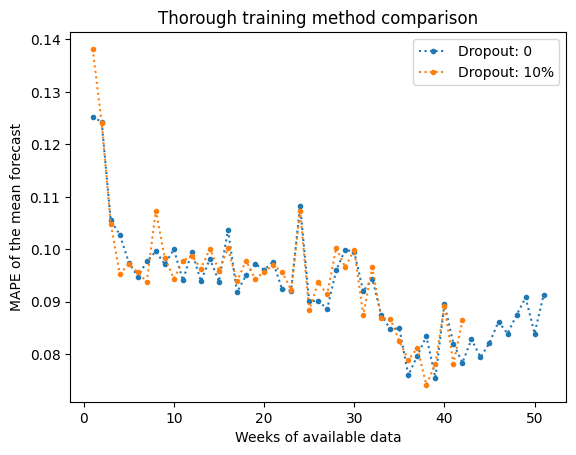

In [24]:
# MAPE of the average forecast
plt.title("Thorough training method comparison")
plt.ylabel("MAPE of the mean forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="Dropout: 0")
plt.errorbar(x=range(1, 43), y=[np.mean(ts) for ts in refit_multiple_passes_v2['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="Dropout: 10%")
plt.legend()
plt.savefig("experiment_results/stage_2_finetune_method_comp/thorough_training_method_comparison.jpeg");

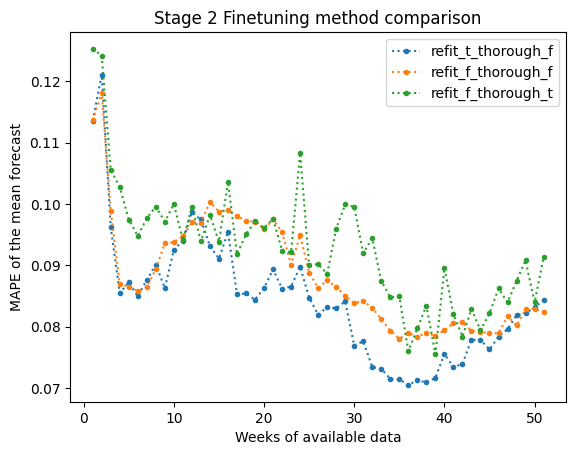

In [25]:
# MAPE of the average forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the mean forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend();
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_mean.jpeg");

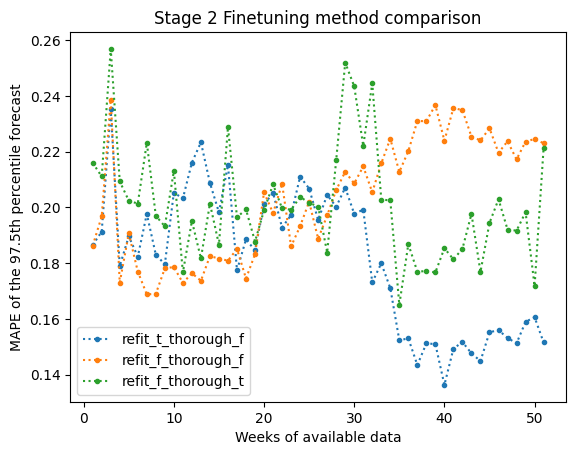

In [26]:
# MAPE of the 97.5th percentile forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the 97.5th percentile forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend();
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_975.jpeg");

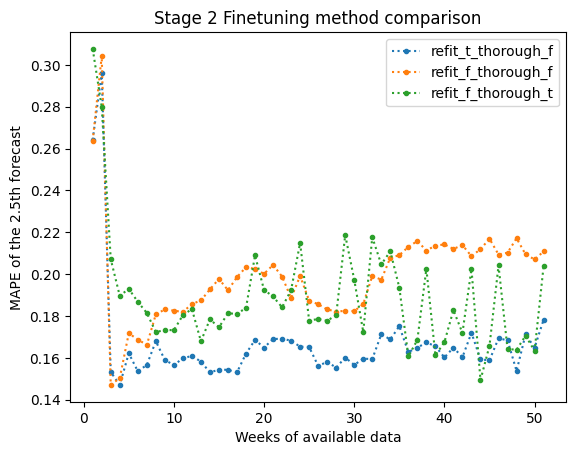

In [27]:
# MAPE of the 2.5th percentile forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the 2.5th forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['lower_0025'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['lower_0025'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['lower_0025'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend()
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_025.jpeg");

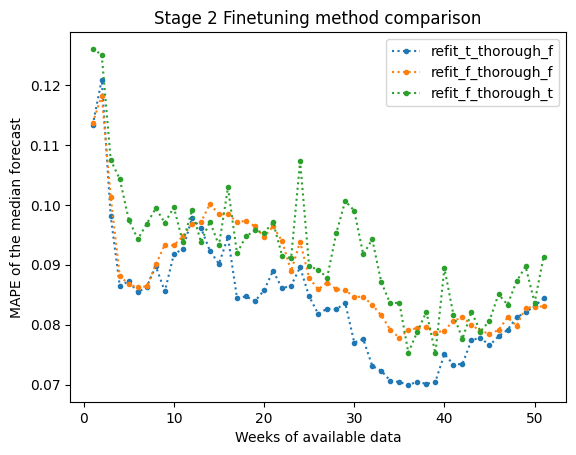

In [28]:
# MAPE of the median forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the median forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['median'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['median'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['median'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend()
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_median.jpeg");